In [86]:
import os
import pandas as pd
import sqlalchemy as sql
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import scipy.optimize as sco

# https://pypi.org/project/yfinance/
import yfinance as yf

import plotly.graph_objects as go
import hvplot.pandas
import holoviews as hv
import seaborn as sns
import copy
import warnings

from pathlib import Path
# https://pandas-datareader.readthedocs.io/en/latest/
from pandas_datareader import data as pdr
from pandas import Timestamp as tstamp
from pandas import read_csv as rcsv
from pandas import read_sql_query as rsqq
from sqlalchemy import (
    create_engine as ce,
    inspect
)

# Import date and timedelta class
from datetime import date
from datetime import timedelta
from scipy import stats

# https://pyportfolioopt.readthedocs.io/en/latest/index.html
from pypfopt import(                        
    EfficientFrontier,
    risk_models,
    expected_returns,
    plotting
)

# https://pyportfolioopt.readthedocs.io/en/latest/index.html
from pypfopt.discrete_allocation import(    
    DiscreteAllocation,
    get_latest_prices
)

from MCForecastTools import MCSimulation
from calculations import MPTCalculations as mpt
from metrics import QuantMetrics as qm
from dataset import DataCollection as ds

warnings.filterwarnings('ignore')

print(f"Package imports and dependencies resolved")

Package imports and dependencies resolved


### PRIMARY IMPORTATION

In [87]:
# Specifiy date range for data
# Set start and end dates of 5 years "5Y" back from your current date
end_date = pd.to_datetime('today')
# 5 years
start_date = end_date - np.timedelta64(5, 'Y')
start, end = start_date, end_date
# Verify date range
print(f"Start dat: {start} and End data: {end}")

Start dat: 2017-10-18 06:43:15.182316 and End data: 2022-10-18 11:49:15.182316


In [88]:
# Specify portfolio sectors - basket of market index and assets - S&P 500 Index (^GSPC) and Tech Stocks List
basket_list = ds.market + ds.tech_list

print(basket_list)

['^GSPC', 'AAPL', 'IBM', 'TSLA', 'GOOGL', 'MSFT', 'CSCO', 'TSM', 'NVDA']


In [89]:
# Dataframe closing prices of basket, i.e. market index and assets
# Fetch data from Yahho Finance API
stock_data, raw_data = ds.get_raw_data(basket_list, start, end)
stock_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)
stock_data = stock_data.reset_index()
raw_data.rename(columns = {'^GSPC':'SP500_index'}, inplace = True)

In [90]:
# Check to see if data diretcory has raw data csv, else download from Yahoo Finance API
if os.path.exists('data/raw_frame_close.csv') == True:
        os.remove('data/raw_frame_close.csv')
        raw_data.to_csv('data/raw_frame_close.csv')
else:
        raw_data.to_csv('data/raw_frame_close.csv')

In [91]:
# Output raw data is raw_frame_close
display(raw_data.shape)
# Review random 5 rows from dataframe
display(raw_data.sample(5))

(1259, 54)

Attributes    Adj Close                                                  \
Symbols     SP500_index        AAPL         IBM        TSLA       GOOGL   
Date                                                                      
2021-09-21  4354.189941  142.630753  120.945793  246.460007  139.033005   
2021-08-03  4423.149902  146.319626  129.550537  236.580002  135.630005   
2020-05-04  2842.739990   72.090355  102.519608   50.745998   66.144997   
2019-01-09  2584.959961   37.054134   96.028839   22.568666   54.082500   
2019-11-12  3091.840088   64.265518  113.058693   23.328667   64.860497   

Attributes                                                       Close  ...  \
Symbols           MSFT       CSCO         TSM        NVDA  SP500_index  ...   
Date                                                                    ...   
2021-09-21  292.351532  53.218727  112.702522  212.289841  4354.189941  ...   
2021-08-03  284.191254  54.172161  115.609932  197.956360  4423.149902  ...   
2020-05-04  174.831314  38.291843   49.689579   72.633209  2842.739990  ...   
2019-01-09  100.173965  38.662487   32.095676   35.392876  2584.959961  ...   
2019-11-12  142.895584  44.048149   48.881107   52.196533  3091.840088  ...   

Attributes        Open        Volume                                       \
Symbols           NVDA   SP500_index         AAPL        IBM         TSLA   
Date                                                                        
2021-09-21  214.169998  3.044300e+09   75834000.0  4261927.0   48992100.0   
2021-08-03  197.399994  3.305340e+09   64786600.0  4272596.0   64860900.0   
2020-05-04   70.220001  4.723140e+09  133568000.0  4202723.0  288556500.0   
2019-01-09   35.474998  4.052480e+09  180396400.0  3800850.0   81493500.0   
2019-11-12   52.430000  3.466010e+09   87388800.0  3186639.0  110391000.0   

Attributes                                                              
Symbols          GOOGL        MSFT        CSCO         TSM        NVDA  
Date                                                                    
2021-09-21  25332000.0  22364100.0  18700600.0   8182200.0  20468800.0  
2021-08-03  20762000.0  17879000.0  17357400.0   5874700.0  30181100.0  
2020-05-04  30806000.0  30372900.0  15997700.0   7514000.0  31755600.0  
2019-01-09  26998000.0  32280800.0  22640000.0  11770300.0  61726000.0  
2019-11-12  28852000.0  18641600.0  15632900.0   8625100.0  28350400.0  

[5 rows x 54 columns]

In [92]:
# Output cleaned data to 'Close' prices is stock_data, cut table down to 29 columns from 174 columns
display(stock_data.shape)
# Review random 5 rows from dataframe
display(stock_data.sample(5)) 

(1259, 10)

Symbols,Date,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
224,2018-09-10,2877.129883,54.582500,139.244736,19.033333,58.752998,109.379997,47.070000,44.619999,68.682503
687,2020-07-14,3197.520020,97.057503,115.296364,101.120003,76.042999,208.350006,46.259998,66.959999,103.769997
491,2019-10-02,2887.610107,54.740002,135.458893,16.208668,58.896000,134.649994,46.560001,46.430000,43.259998
522,2019-11-14,3096.629883,65.660004,128.107071,23.290001,65.457497,148.059998,44.910000,52.480000,52.447498
1062,2022-01-06,4696.049805,172.000000,135.339996,354.899994,137.747498,313.880005,60.919998,128.470001,281.779999


### START CSV
#### Input pandas dataframe is **raw_frame_close** 
#### CSV path is 'data/raw_frame_close.csv'
#### Output pandas dataframe name is working_raw_frame_close

In [93]:
# TODO

In [94]:
# Import the [offline stored] data by read in csv file
# Generate dataframe setting the DatetimeIndex with 'date' as as index. 
working_raw_data = rcsv(
    Path('data/raw_frame_close.csv'),
    index_col=0,
    parse_dates=True,
    infer_datetime_format=True,
    header = [0,1]
)

# Output dataframe name is working_raw_frame_close
print('Sample row of DataFrame from local csv data source path:')
display(working_raw_data.shape)

# Display sample 5 rows of dataframe
display(working_raw_data.sample(5))

Sample row of DataFrame from local csv data source path:


(1259, 54)

Attributes    Adj Close                                                  \
Symbols     SP500_index        AAPL         IBM        TSLA       GOOGL   
Date                                                                      
2018-06-13  2775.629883   45.770306  113.752235   22.985332   57.211498   
2021-06-02  4208.120117  124.177078  131.034286  201.706665  118.529503   
2018-09-05  2888.600098   54.642506  115.224754   18.716000   59.955002   
2019-09-18  3006.729980   54.487614  117.202675   16.232668   61.632500   
2018-06-22  2754.879883   44.383026  109.811531   22.242001   58.464500   

Attributes                                                       Close  ...  \
Symbols           MSFT       CSCO         TSM        NVDA  SP500_index  ...   
Date                                                                    ...   
2018-06-13   96.101700  38.415359   33.954334   65.035309  2775.629883  ...   
2021-06-02  244.777466  50.650558  115.693352  167.580124  4208.120117  ...   
2018-09-05  103.779846  41.582531   39.855957   69.043571  2888.600098  ...   
2019-09-18  134.588272  44.593723   41.914963   44.818146  3006.729980  ...   
2018-06-22   95.682434  37.708321   33.145695   62.197449  2754.879883  ...   

Attributes        Open        Volume                                       \
Symbols           NVDA   SP500_index         AAPL        IBM         TSLA   
Date                                                                        
2018-06-13   65.660004  3.779230e+09   86553600.0  3104737.0  142047000.0   
2021-06-02  162.522507  4.860930e+09   59278900.0  2915097.0   69908400.0   
2018-09-05   70.747498  3.241250e+09  133332000.0  3270319.0  115812000.0   
2019-09-18   45.197498  3.435540e+09  101360000.0  2074846.0   62553000.0   
2018-06-22   64.487503  5.450550e+09  108801600.0  5869420.0  153991500.0   

Attributes                                                              
Symbols          GOOGL        MSFT        CSCO         TSM        NVDA  
Date                                                                    
2018-06-13  34302000.0  29492900.0  24383200.0   9616600.0  33820800.0  
2021-06-02  21158000.0  19406700.0  14529300.0   5383400.0  59416800.0  
2018-09-05  53988000.0  32872400.0  20818100.0   7262400.0  39315600.0  
2019-09-18  17440000.0  23982100.0  12563800.0   4044800.0  25815200.0  
2018-06-22  34220000.0  38923100.0  27460000.0  10338500.0  43416000.0  

[5 rows x 54 columns]

In [95]:
# Verify Close columns of each stocks and index
working_raw_data['Close']

Symbols,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,,
2017-10-18,2561.260010,39.939999,152.514343,23.976667,50.637001,77.610001,33.549999,41.500000,49.395000
2017-10-19,2562.100098,38.994999,153.824097,23.454000,50.091999,77.910004,33.750000,41.070000,49.450001
2017-10-20,2575.209961,39.062500,154.942642,23.006666,50.253502,78.809998,34.250000,41.119999,49.224998
2017-10-23,2564.979980,39.042500,152.533463,22.468000,49.277000,78.830002,34.349998,41.209999,49.154999
2017-10-24,2569.129883,39.275002,149.024857,22.489332,49.424500,78.860001,34.580002,41.320000,49.669998
...,...,...,...,...,...,...,...,...,...
2022-10-12,3577.030029,138.339996,117.570000,217.240005,97.559998,225.750000,39.270000,64.110001,115.000000
2022-10-13,3669.909912,142.990005,121.790001,221.720001,99.059998,234.240005,40.610001,66.620003,119.599998
2022-10-14,3583.070068,138.380005,120.040001,204.990005,96.559998,228.559998,40.200001,63.919998,112.269997


### START SQlite
#### Input pandas dataframe is **raw_frame_close** 
#### SQlite database table name is basket
#### Output pandas dataframe name is sql_basket_df

In [96]:
# Fetch date indexed and unindexed data frames created out of SQLite temp db
sql_basket_indexed_df, sql_basket_df = ds.sqlite_data(stock_data)

print("Unindexed dataframe counts and column summary")
display(sql_basket_df.shape) 
# Display sample 5 rows of unindexed dataframe
display(sql_basket_df.sample(5))

print("Indexed dataframe counts and column summary")
display(sql_basket_indexed_df.shape) 

# Display sample 5 rows of indexed datafarme
display(sql_basket_indexed_df.sample(5))

Undexed dataframe counts and column summary


(1259, 10)

,Date,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
699,2020-07-30,3246.219971,96.190002,117.495216,99.166000,76.918503,203.899994,46.439999,79.930000,106.139999
859,2021-03-19,3913.100098,119.989998,123.231361,218.289993,101.348000,230.350006,48.980000,113.629997,128.457504
130,2018-04-26,2666.939941,41.055000,140.267685,19.032000,52.165501,94.260002,44.209999,38.169998,56.305000
1251,2022-10-07,3639.659912,140.089996,118.820000,223.070007,98.680000,234.240005,40.270000,69.750000,120.760002
942,2021-07-19,4258.490234,142.449997,131.854691,215.406662,124.578003,277.010010,53.060001,115.349998,187.797501


Indexed dataframe counts and column summary


(1259, 9)

,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,,
2020-12-29,3727.040039,134.869995,118.355644,221.996674,87.888000,224.149994,44.639999,105.559998,129.432495
2022-04-14,4392.589844,165.289993,126.559998,328.333344,126.730003,279.829987,51.169998,98.360001,212.580002
2018-03-13,2765.310059,44.992500,152.313583,22.789333,56.995499,94.410004,45.160000,44.990002,61.927502
2020-10-30,3269.959961,108.860001,106.749519,129.346664,80.805496,202.470001,35.900002,83.870003,125.339996
2021-04-23,4180.169922,134.320007,136.166351,243.133331,114.996498,261.149994,51.910000,118.639999,152.652496


### INTERFACE stratis

In [97]:
# Display constants being used in quant analysis
print("Number of trading days per year = ", qm.num_trading_days)
print("Risk free rate = ", qm.risk_free_rate)
print("Number of random portfolio runs = ", qm.num_random_portfolio_run)
print("Number of days in rolling window = ", qm.rolling_window_days)
print("Number of days of input dataframe to use as historical data = ", mpt.historical_days_percent)
print("Number of days of input dataframe to use as test/experiment data  = ", mpt.test_days_percent)

Number of trading days per year =  252
Risk free rate =  0.0275
Number of random portfolio runs =  10000
Number of days in rolling window =  20
Number of days of input dataframe to use as historical data =  0.75
Number of days of input dataframe to use as test/experiment data  =  0.25


In [98]:
# Break up the input asset price data frame into 2 chunks
# (1) For use of historical data to determine what the optimum portfolio selection should be
# (2) For test purposes,test how wll the portfolio allocation performs
num_days_total = sql_basket_indexed_df.shape[0]
num_historical_days_percent = round(num_days_total * mpt.historical_days_percent)
num_test_days_percent = round(num_days_total * mpt.test_days_percent)

print("Total # of days in asset dataframe = ", num_days_total)
print("Total # of days will use for hisotrical data = ", num_historical_days_percent)
print("Total # of days will use for testing results = ", num_test_days_percent)


# Extract the days from full dataframe will use for historical data
asset_mkt_prices_historical_df = sql_basket_indexed_df.iloc[0:num_historical_days_percent-1, :].copy()
asset_mkt_prices_test_df = sql_basket_indexed_df.iloc[num_historical_days_percent:num_days_total-1,:].copy()

Total # of days in asset dataframe =  1259
Total # of days will use for hisotrical data =  944
Total # of days will use for testing results =  315


In [99]:
# Plot the asset prices
asset_mkt_prices_historical_df.hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="Performance of Historical Market & Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [100]:
# Plot the asset prices
asset_mkt_prices_test_df.hvplot.line(
    ylabel="Prices", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="(Test) Market & Assets Prices"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [101]:
# Compute the frequency components on asset prices
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_mkt_prices_historical_df)

In [102]:
# Review daily returns DataFrame.
print("Asset Returns:")
display(asset_mkt_prices_returns_df.shape)
display(asset_mkt_prices_returns_df.sample())

Asset Retuns:


(942, 9)

,SP500_index,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,,
2021-04-19,-0.005307,0.005069,-0.003518,-0.033997,0.003071,-0.00767,0.000947,-0.028946,-0.034611


In [103]:
# Plot the asset cumulative returns
asset_mkt_prices_cum_returns_df.hvplot.line(
    ylabel="Cum Returns", 
    xlabel="Date",
    width = 800,
    height = 500,
    hover_color = 'magenta',
    title="Market & Assets Cumulative Returns"
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

<AxesSubplot:title={'center':'Asset & Market: Daily Returns Box Plot'}>

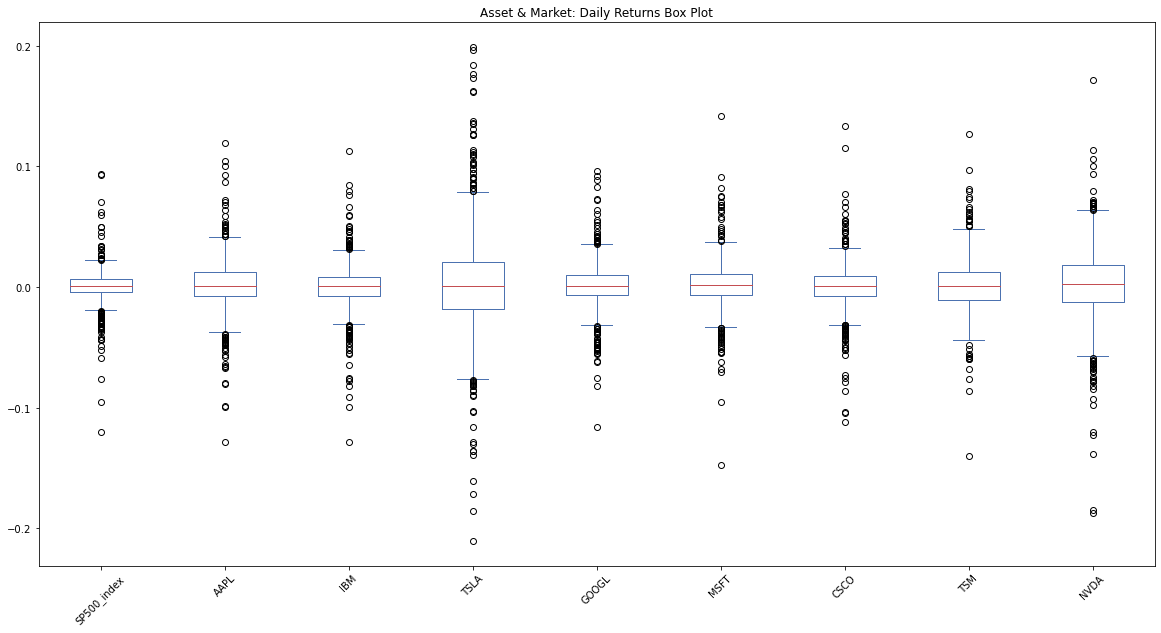

In [104]:
# Use the daily return data to create box plots to visualize the volatility of the assets 
asset_mkt_prices_returns_df.plot.box(figsize=(20, 10), rot=45, title = "Asset & Market: Daily Returns Box Plot")

In [105]:
# Sort the asset deviations
asset_mkt_prices_ann_std_sorted_df = asset_mkt_prices_ann_std_df.sort_values()

print("Asset annualized standard deviations (Sorted):")
display(asset_mkt_prices_ann_std_sorted_df)

Asset annualized standard deviations (Sorted):


SP500_index    0.215597
IBM            0.286931
GOOGL          0.295233
CSCO           0.296555
MSFT           0.304197
AAPL           0.334059
TSM            0.340231
NVDA           0.480390
TSLA           0.656076
dtype: float64

In [106]:
# Dispaly the (sorted) asset sharpe ratios
print("Assets & Market: Annual Sharpe Ratio (Sorted):")
display(asset_prices_sharpe_ratio_df.sort_values())

asset_prices_sharpe_ratio_df.hvplot(
    kind = 'bar',
    width = 800,
    height = 500,
    hover_color = 'magenta',
    rot = 45,
    title = "Assets & Market: Annual Sharpe Ratio")

Assets & Market: Annual Sharpe Ratio (Sorted):


IBM            0.008716
CSCO           0.562203
SP500_index    0.739498
GOOGL          0.963853
TSM            0.974125
NVDA           0.987275
AAPL           1.186144
TSLA           1.222170
MSFT           1.271766
dtype: float64

:Bars   [index]   (0)

In [107]:
# Drop the market from asset/mkt data frame
asset_prices_df = asset_mkt_prices_historical_df.drop(['SP500_index'], axis=1, inplace=False)
print("Asset Prices DataFrame (does not include market)")
display(asset_prices_df)

# Recompute frequence components (e.g. covariance matrix will be different).  TODO: Optimize dataframe creating by sharing data
asset_mkt_prices_returns_df,        \
asset_mkt_prices_ann_returns_mean,  \
asset_mkt_prices_std_df,            \
asset_mkt_prices_ann_std_df,        \
asset_mkt_prices_std_rolling_df,    \
asset_mkt_prices_ann_cov_mtrx_df,   \
asset_mkt_prices_ann_corr_mtrx_df,  \
asset_mkt_prices_cum_returns_df,    \
asset_prices_sharpe_ratio_df,       \
log_returns                           = qm.mpt_qa_compute_freq_stats(asset_prices_df)

Asset Prices DataFrame (does not include market)


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
Date,,,,,,,,
2017-10-18,39.939999,152.514343,23.976667,50.637001,77.610001,33.549999,41.500000,49.395000
2017-10-19,38.994999,153.824097,23.454000,50.091999,77.910004,33.750000,41.070000,49.450001
2017-10-20,39.062500,154.942642,23.006666,50.253502,78.809998,34.250000,41.119999,49.224998
2017-10-23,39.042500,152.533463,22.468000,49.277000,78.830002,34.349998,41.209999,49.154999
2017-10-24,39.275002,149.024857,22.489332,49.424500,78.860001,34.580002,41.320000,49.669998
...,...,...,...,...,...,...,...,...
2021-07-13,145.639999,134.110901,222.846664,127.341499,280.980011,53.320000,123.900002,202.500000
2021-07-14,149.149994,133.671127,217.793335,128.237000,282.510010,54.090000,124.389999,198.414993
2021-07-15,148.479996,134.273422,216.866669,127.004997,281.029999,53.650002,117.529999,189.662506


In [108]:
print("Annual Covariance Matrix:")
# TODO: display(asset_prices_ann_cov_mtrx_df.head())

display(asset_mkt_prices_ann_cov_mtrx_df.head())

print("Correlation Matrix:")
# TODO display(asset_prices_ann_corr_mtrx_df.head())
display(asset_mkt_prices_ann_corr_mtrx_df)

Annual Covariance Matrix:


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
AAPL,0.111595,0.045578,0.092344,0.066799,0.076999,0.060046,0.064491,0.103660
IBM,0.045578,0.082329,0.044179,0.043538,0.047714,0.054138,0.043616,0.059229
TSLA,0.092344,0.044179,0.430436,0.072725,0.086827,0.054394,0.081187,0.132986
GOOGL,0.066799,0.043538,0.072725,0.087163,0.071124,0.052017,0.053407,0.090669
MSFT,0.076999,0.047714,0.086827,0.071124,0.092536,0.061016,0.060100,0.102463


Correlation Matrix:


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
AAPL,1.000000,0.475503,0.421340,0.677300,0.757720,0.606113,0.567416,0.645942
IBM,0.475503,1.000000,0.234684,0.513961,0.546659,0.636237,0.446780,0.429696
TSLA,0.421340,0.234684,1.000000,0.375458,0.435055,0.279570,0.363711,0.421947
GOOGL,0.677300,0.513961,0.375458,1.000000,0.791953,0.594122,0.531686,0.639296
MSFT,0.757720,0.546659,0.435055,0.791953,1.000000,0.676373,0.580695,0.701161
CSCO,0.606113,0.636237,0.279570,0.594122,0.676373,1.000000,0.487977,0.548837
TSM,0.567416,0.446780,0.363711,0.531686,0.580695,0.487977,1.000000,0.625009
NVDA,0.645942,0.429696,0.421947,0.639296,0.701161,0.548837,0.625009,1.000000


[Text(0.5, 1.0, 'Asset Prices Correlation Matrix')]

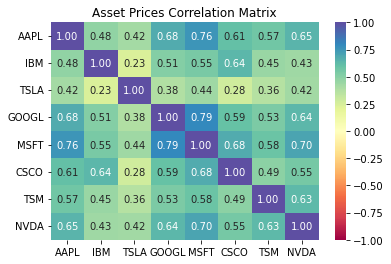

In [109]:
# Use the `heatmap` function from the seaborn library to visualize the correlation matrix
sns.heatmap(
    asset_mkt_prices_ann_corr_mtrx_df, 
    annot=True, 
    vmin=-1, 
    vmax=1, 
    fmt=".2f", 
    cmap="Spectral"
).set(
    title='Asset Prices Correlation Matrix')

In [110]:
print("Annual average asset returns:")
display(asset_mkt_prices_ann_returns_mean)

Annual average asset returns:


AAPL     0.396242
IBM      0.002501
TSLA     0.801837
GOOGL    0.284562
MSFT     0.386867
CSCO     0.166724
TSM      0.331428
NVDA     0.474277
dtype: float64

### Efficient Frontier Computation

In [111]:
# Determine the efficient frontier components
efficient_frontier_df = qm.mpt_qa_get_efficient_frontier(asset_prices_df, asset_mkt_prices_ann_returns_mean, asset_mkt_prices_ann_cov_mtrx_df)

print("Efficient Frontier DataFrame:")
display(efficient_frontier_df.shape)

print("Print random 5 rows of Efficient Frontier sample points")
display(efficient_frontier_df.sample(5))

Efficient Frontier DataFrame:


(10000, 11)

Print random 5 rows of Efficient Frontier sample points


,Returns,Volatility,SharpeRatio,AAPL_W,IBM_W,TSLA_W,GOOGL_W,MSFT_W,CSCO_W,TSM_W,NVDA_W
2247,0.394808,4.779015,0.076858,0.008886,0.171897,0.216376,0.083658,0.213779,0.010792,0.214760,0.079853
383,0.323564,4.450640,0.066522,0.121014,0.170038,0.050673,0.076788,0.171088,0.091536,0.139818,0.179046
7090,0.393439,4.630400,0.079030,0.021676,0.035155,0.171453,0.173434,0.197938,0.135638,0.187623,0.077081
1655,0.392115,4.819410,0.075656,0.263892,0.014656,0.099382,0.076784,0.115814,0.184435,0.040560,0.204476
241,0.383478,4.983110,0.071437,0.084647,0.284150,0.264555,0.012014,0.140120,0.053117,0.041529,0.119868


Text(0.5, 1.0, 'Efficient Frontier')

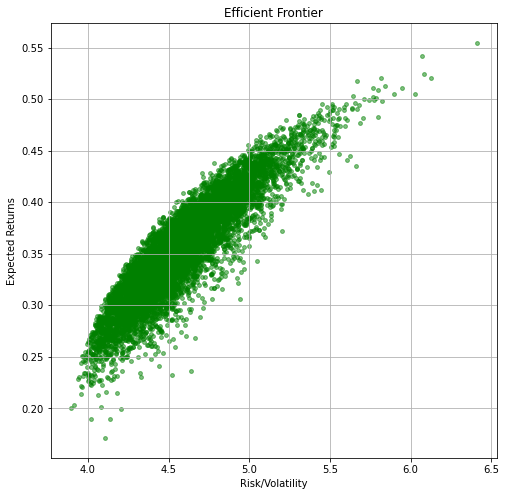

In [112]:
# Plot the efficient frontier #1 (Just the plain efficient frontier)
efficient_frontier_df.plot(
    kind = "scatter",
    x = 'Volatility',
    y = 'Returns',
    color = 'g',
    marker = 'o',
    s = 15,
    alpha = 0.5,
    grid = True,
    figsize = [8,8]
)
plt.xlabel('Risk/Volatility')
plt.ylabel('Expected Returns')
plt.title("Efficient Frontier")

In [113]:
# Select the following portfolio allocations:
# (1) Based on the "minimum" risk
# (2) Based on the "maximum" risk
# (3) Based on the "optimum sharpe ratio"
portfolio_min_volatility, portfolio_max_volatility, portfolio_opt_sharpe_ratio = qm.mpt_qa_return_portfolio_allocations(efficient_frontier_df)

print("Efficient Frontier: Min Volatility Point:")
display(portfolio_min_volatility)
print("\nEfficient Frontier: Max Volatility Point:")
display(portfolio_max_volatility)
print("\nEfficient Frontier: Opt Sharpe Ratio Volatility Point:")
display(portfolio_opt_sharpe_ratio)

Efficient Frontier: Min Volatility Point:


Returns        0.200451
Volatility     3.894268
SharpeRatio    0.044412
AAPL_W         0.057491
IBM_W          0.295694
TSLA_W         0.005887
GOOGL_W        0.245403
MSFT_W         0.056477
CSCO_W         0.202813
TSM_W          0.125290
NVDA_W         0.010945
Name: 7988, dtype: float64


Efficient Frontier: Max Volatility Point:


Returns        0.554737
Volatility     6.410150
SharpeRatio    0.082250
AAPL_W         0.149445
IBM_W          0.007417
TSLA_W         0.353948
GOOGL_W        0.056731
MSFT_W         0.035350
CSCO_W         0.016950
TSM_W          0.008769
NVDA_W         0.371392
Name: 876, dtype: float64


Efficient Frontier: Opt Sharpe Ratio Volatility Point:


Returns        0.517581
Volatility     5.670000
SharpeRatio    0.086434
AAPL_W         0.246010
IBM_W          0.016130
TSLA_W         0.363341
GOOGL_W        0.035258
MSFT_W         0.208812
CSCO_W         0.037355
TSM_W          0.087333
NVDA_W         0.005761
Name: 8696, dtype: float64

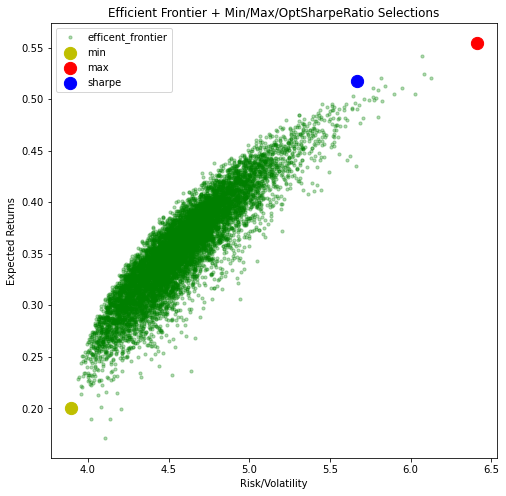

In [114]:
# Plot the efficient frontier #2 (Efficient frontier with selected portfolio points)

plt.subplots(figsize=(8,8))

plt.scatter(
    efficient_frontier_df['Volatility'],
    efficient_frontier_df['Returns'],
    color = 'g',
    marker = 'o',
    s = 10,
    alpha = 0.3
)

plt.scatter(portfolio_min_volatility[1], portfolio_min_volatility[0], color='y', marker='o', s=150)
plt.scatter(portfolio_max_volatility[1], portfolio_max_volatility[0], color='r', marker='o', s=150)
plt.scatter(portfolio_opt_sharpe_ratio[1], portfolio_opt_sharpe_ratio[0], color='b', marker='o', s=150)

plt.xlabel('Risk/Volatility')
plt.ylabel('Expected Returns')
plt.title("Efficient Frontier + Min/Max/OptSharpeRatio Selections")
plt.legend(["efficent_frontier", "min" , "max", "sharpe"])

In [115]:
# Plot the efficient frontier #3 (Efficient frontier + porfolio selection points + 3rd color dimension of the sharpe ratio points)
scatter = hv.Scatter((efficient_frontier_df['Volatility'], efficient_frontier_df['Returns'], efficient_frontier_df.loc[:,'SharpeRatio']), 'Volatility', ['Return', 'Sharpe Ratio'])
max_sharpe = hv.Scatter([(portfolio_opt_sharpe_ratio[1],portfolio_opt_sharpe_ratio[0])])
min_volatility = hv.Scatter([(portfolio_min_volatility[1],portfolio_min_volatility[0])])
max_volatility = hv.Scatter([(portfolio_max_volatility[1],portfolio_max_volatility[0])])

scatter.opts(title="Efficient Frontier + Min/Max/OptSharpeRatio Selections", color='Sharpe Ratio', cmap='plasma', width=800, height=600, colorbar=True, padding=0.1) *\
max_sharpe.opts(color='blue', line_color='black', size=15,) *\
min_volatility.opts(color='yellow', line_color='black', size=15) *\
max_volatility.opts(color='red', line_color='black', size=15)


:Overlay
   .Scatter.I   :Scatter   [Volatility]   (Return,Sharpe Ratio)
   .Scatter.II  :Scatter   [x]   (y)
   .Scatter.III :Scatter   [x]   (y)
   .Scatter.IV  :Scatter   [x]   (y)

### Visualization for: "mpt_performance_eval.py"

KeyError: 'SP500_index'

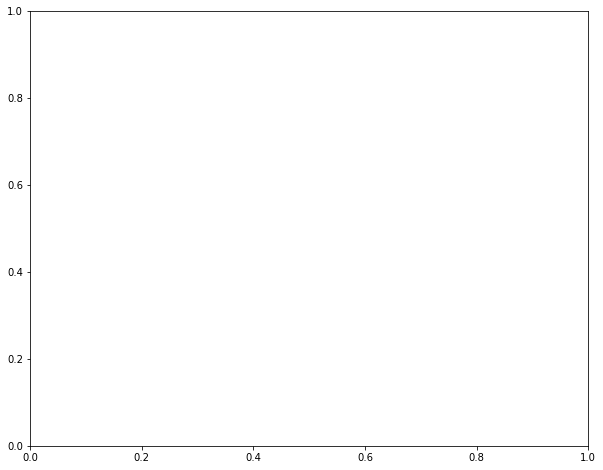

In [116]:
portfolio_min_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_min_volatility)
portfolio_max_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_max_volatility)
portfolio_opt_sharpe_ratio_volatility_returns_df = mpt.mpt_pe_compute_portfolio_returns(asset_mkt_prices_returns_df, portfolio_opt_sharpe_ratio)

plt.subplots(figsize=(10,8))

sns.regplot(asset_mkt_prices_returns_df['SP500_index'], portfolio_max_volatility_returns_df, color='r')
sns.regplot(asset_mkt_prices_returns_df['SP500_index'], portfolio_opt_sharpe_ratio_volatility_returns_df, color='b')
sns.regplot(asset_mkt_prices_returns_df['SP500_index'], portfolio_min_volatility_returns_df, color='y')
plt.xlabel("Market Returns (yellow=Min, blue=OptSharpe, red=Max")
plt.ylabel("Portfolio Returns")
plt.legend(["Max", "", "", "OptSharpe", "", "", "Min"])
plt.title("Combininig Min/Max/OptSharpe Portfolio Selection Returns vs Market Returns")
plt.show()

# TODO:  Clean up legend (not sure how to do exclude parts of legend)

# TODO: Not running at the moment


<AxesSubplot:title={'center':'Portfolio Composition - Min Protfolio'}, ylabel='weights'>

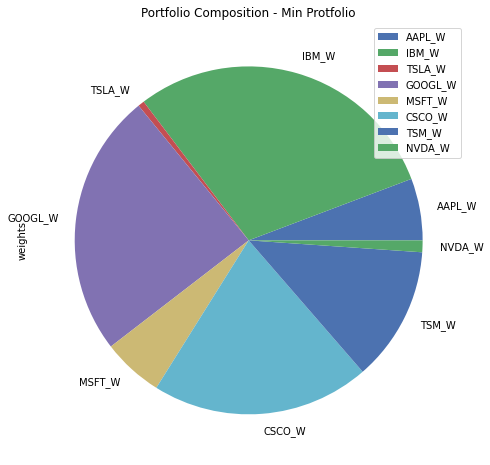

In [117]:
portfolio_min_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_min_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_min_weights.plot.pie(
    y='weights', 
    title='Portfolio Composition - Min Protfolio',
    figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Max Protfolio'}, ylabel='weights'>

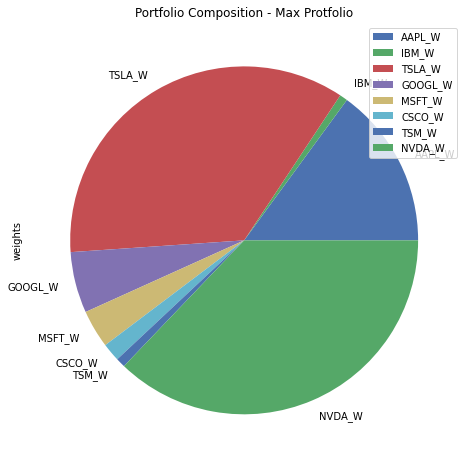

In [118]:
portfolio_max_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_max_volatility)

# Plot the pie charts of the porfolio allocation/weights
portfolio_max_weights.plot.pie(y='weights', title='Portfolio Composition - Max Protfolio', figsize=(10,8))

<AxesSubplot:title={'center':'Portfolio Composition - Opt Sharpe Ratio Protfolio'}, ylabel='weights'>

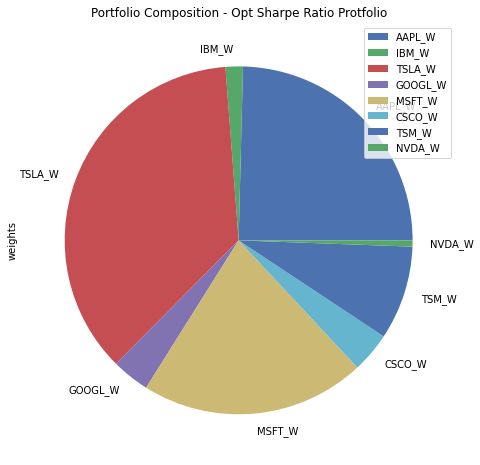

In [119]:
portfolio_opt_sharpe_ratio_weights = mpt.mpt_pe_get_portfolio_weights_df(portfolio_opt_sharpe_ratio)

# Plot the pie charts of the porfolio allocation/weights
portfolio_opt_sharpe_ratio_weights.plot.pie(y='weights', title='Portfolio Composition - Opt Sharpe Ratio Protfolio', figsize=(10,8))

### Compute Actual Realized Portfolio Value under the Test dataframe components

In [120]:
asset_prices_test_beg_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_historical_days_percent, :]).drop('SP500_index', axis=0, inplace=False)
asset_prices_test_end_df = pd.DataFrame(sql_basket_indexed_df.iloc[num_days_total-1, :]).drop('SP500_index', axis=0, inplace=False)

print("Beginning and end dates used for the testing the performance of the portfolio")
display(asset_prices_test_beg_df.T)
display(asset_prices_test_end_df.T)

Beginning and end dates used for the testing the performance of the portfolio


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
2021-07-21,145.399994,135.086044,218.429993,127.549004,281.399994,53.880001,117.870003,194.100006


,AAPL,IBM,TSLA,GOOGL,MSFT,CSCO,TSM,NVDA
2022-10-18,143.740005,122.160004,219.414993,100.609703,236.634995,41.444801,63.139999,117.419998


### Monte Carlo dataframe weights list

In [121]:
# Arrange Monte Carlo dataframe weights list
portfolio_mc_min_weights = mpt.mpt_pe_get_mc_weights(portfolio_min_weights)
portfolio_mc_max_weights = mpt.mpt_pe_get_mc_weights(portfolio_max_weights)
portfolio_mc_opt_sharpe_ratio_weights = mpt.mpt_pe_get_mc_weights(portfolio_opt_sharpe_ratio_weights)

In [122]:
investment_pnl_min = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_min_weights))[0][0]
investment_pnl_max = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_max_weights))[0][0]
investment_pnl_opt_sharpe_ratio = mpt.mpt_pe_compute_investment_pnl(mpt.initial_test_investment, asset_prices_test_beg_df, asset_prices_test_end_df, pd.DataFrame(portfolio_mc_opt_sharpe_ratio_weights))[0][0]

print("Actual realized portfolio value for min/max/opt_sharpe allocations:")
display(investment_pnl_min)
display(investment_pnl_max)
display(investment_pnl_opt_sharpe_ratio)

Actual realized portfolio value for min/max/opt_sharpe allocations:


8034.196891784668

8127.728126525879

8986.162658691406

### Run Monte Carlo Simulations on the test dataframe and compute expected Returns and compare agains realized returns

In [123]:
print("Number of MC runs:", mpt.num_mc_runs)

Number of MC runs: 500


In [124]:
# Slice the "test" dataframe to use for MC sims to predict returns
asset_mc_test_df = asset_mkt_prices_test_df.drop('SP500_index', axis=1, inplace=False)

In [125]:
# Arrange Monte Carlo dataframe to have tuples for column names
asset_prices_mc_col_df = mpt.mpt_pe_get_mc_porfolio_df(asset_mc_test_df)

In [126]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_min_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_min_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = qm.num_trading_days * mpt.num_mc_years
)

# Review the simulation input data
print("Monte Carlo Portfolio (Min)")
MC_min_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Min)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-11  138.979996    -0.010255  117.800003     0.000425  216.500000   
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   

                             GOOGL                     MSFT               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2022-10-11    -0.028974  97.180000    -0.006949  225.410004    -0.016750   
2022-10-12     0.003418  97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622  99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456  96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052  99.970001     0.035315  237.529999     0.039246   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-11  39.580002    -0.007771  63.450001    -0.059164  115.860001   
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   

                         
           daily_return  
Date                     
2022-10-11    -0.007198  
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876

In [127]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_min_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.019165,1.010131,1.003628,0.990609,0.999972,0.982659,0.997280,1.010023,0.990552,0.994228,...,0.998782,0.990084,0.987725,0.998878,0.996909,0.993847,0.998150,0.999018,0.991620,0.991539
2,1.021552,1.013456,1.013428,0.997279,1.001363,0.990378,1.003509,0.995022,0.992552,1.003785,...,0.993671,0.991144,0.980750,1.003536,1.002453,0.985935,0.991707,1.007182,0.999752,0.985645
3,1.032459,1.004940,1.010083,1.006248,0.989668,0.984350,0.996039,0.996563,0.991838,1.000008,...,1.002034,0.999476,0.973644,1.003383,1.000379,0.983051,0.999341,1.019943,0.998435,0.980364
4,1.044223,0.997075,1.021338,0.999154,0.969604,0.986030,1.006224,1.000051,0.985012,0.993264,...,0.994807,0.988621,0.977251,1.013085,1.003081,0.972464,0.999385,1.014755,1.008374,0.984774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.396409,0.563019,0.712893,0.563010,0.500707,0.586467,0.484739,0.367378,0.405991,0.697271,...,0.368391,0.269542,0.596199,0.686456,0.443733,0.324814,0.461193,0.324507,0.555004,0.587243
1257,0.393719,0.557394,0.703995,0.565718,0.499994,0.590259,0.485450,0.362945,0.402636,0.702869,...,0.364994,0.270023,0.596529,0.678638,0.440607,0.327739,0.468693,0.328836,0.548069,0.580469
1258,0.397353,0.561598,0.701392,0.558807,0.495044,0.589567,0.479542,0.360043,0.399862,0.703966,...,0.371111,0.270029,0.601315,0.684167,0.441708,0.328389,0.462734,0.325614,0.544794,0.577367
1259,0.398892,0.554751,0.696540,0.554223,0.496936,0.589563,0.476932,0.358765,0.403616,0.709833,...,0.368620,0.271036,0.591031,0.684219,0.441343,0.330167,0.455435,0.326616,0.550425,0.564996


In [128]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.
MC_max_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_max_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = qm.num_trading_days * mpt.num_mc_years
)

# Review the simulation input data
print("Monte Carlo Portfolio (Max)")
MC_max_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Max)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-11  138.979996    -0.010255  117.800003     0.000425  216.500000   
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   

                             GOOGL                     MSFT               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2022-10-11    -0.028974  97.180000    -0.006949  225.410004    -0.016750   
2022-10-12     0.003418  97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622  99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456  96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052  99.970001     0.035315  237.529999     0.039246   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-11  39.580002    -0.007771  63.450001    -0.059164  115.860001   
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   

                         
           daily_return  
Date                     
2022-10-11    -0.007198  
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876

In [129]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_max_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.013941,1.017973,0.998026,0.969897,0.979539,1.006634,0.968601,1.048072,0.992800,1.007402,...,1.011358,1.002947,0.996253,1.000179,1.006697,0.972064,0.975032,0.939443,0.988838,0.972842
2,1.015460,1.009713,0.991000,0.968240,0.974035,1.013847,0.965473,1.014281,0.987985,1.021705,...,1.035369,1.004244,0.985009,0.996072,1.033955,1.022348,0.973048,0.921138,0.946448,0.972258
3,1.028212,1.022124,0.994793,0.993324,0.988460,0.996925,0.996685,0.995060,1.043997,1.041929,...,1.034853,1.017587,0.990183,0.973491,1.017212,1.013514,0.973212,0.900777,0.933803,0.976002
4,1.021273,1.037603,0.984503,0.977421,1.005390,0.992564,0.961867,0.967734,1.035677,1.033012,...,1.013900,1.034317,0.974179,0.966590,1.051014,1.018236,0.994684,0.912840,0.947046,0.959871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,0.295853,1.583771,2.227823,2.101894,0.386735,0.351851,3.462449,2.045905,1.404226,1.775447,...,0.585389,0.395291,0.560339,1.283434,0.758789,0.476262,1.091643,0.572349,1.511531,1.110857
1257,0.303333,1.517906,2.195256,2.060499,0.391504,0.346926,3.276517,2.071679,1.434253,1.802719,...,0.573610,0.382985,0.579301,1.291681,0.765615,0.484812,1.098162,0.569759,1.526195,1.110130
1258,0.295022,1.552864,2.193514,2.121081,0.391707,0.351883,3.315305,2.044053,1.463608,1.801721,...,0.563381,0.375840,0.590654,1.311351,0.772876,0.494981,1.078994,0.545008,1.512025,1.098828
1259,0.283359,1.556607,2.172429,2.146742,0.392862,0.364525,3.313940,2.038776,1.528036,1.802166,...,0.580884,0.369497,0.597260,1.309023,0.765562,0.494089,1.087224,0.554690,1.501627,1.117077


In [130]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# The weights should be split 40% to AGG and 60% to SPY.
# Run 500 samples.


# TODO: Needs to be 1-year in mpt.num_mc_years

MC_opt_sharpe_ratio_portfolio = MCSimulation(
    portfolio_data = asset_prices_mc_col_df,
    weights = portfolio_mc_opt_sharpe_ratio_weights,
    num_simulation = mpt.num_mc_runs,
    num_trading_days = qm.num_trading_days * mpt.num_mc_years
)

# Review the simulation input data
print("Monte Carlo Portfolio (Opt Sharpe)")
MC_opt_sharpe_ratio_portfolio.portfolio_data.tail()

Monte Carlo Portfolio (Opt Sharpe)


AAPL                      IBM                     TSLA  \
                 close daily_return       close daily_return       close   
Date                                                                       
2022-10-11  138.979996    -0.010255  117.800003     0.000425  216.500000   
2022-10-12  138.339996    -0.004605  117.570000    -0.001952  217.240005   
2022-10-13  142.990005     0.033613  121.790001     0.035894  221.720001   
2022-10-14  138.380005    -0.032240  120.040001    -0.014369  204.990005   
2022-10-17  142.410004     0.029123  121.519997     0.012329  219.350006   

                             GOOGL                     MSFT               \
           daily_return      close daily_return       close daily_return   
Date                                                                       
2022-10-11    -0.028974  97.180000    -0.006949  225.410004    -0.016750   
2022-10-12     0.003418  97.559998     0.003910  225.750000     0.001508   
2022-10-13     0.020622  99.059998     0.015375  234.240005     0.037608   
2022-10-14    -0.075456  96.559998    -0.025237  228.559998    -0.024249   
2022-10-17     0.070052  99.970001     0.035315  237.529999     0.039246   

                 CSCO                     TSM                     NVDA  \
                close daily_return      close daily_return       close   
Date                                                                     
2022-10-11  39.580002    -0.007771  63.450001    -0.059164  115.860001   
2022-10-12  39.270000    -0.007832  64.110001     0.010402  115.000000   
2022-10-13  40.610001     0.034123  66.620003     0.039151  119.599998   
2022-10-14  40.200001    -0.010096  63.919998    -0.040528  112.269997   
2022-10-17  41.299999     0.027363  64.889999     0.015175  118.879997   

                         
           daily_return  
Date                     
2022-10-11    -0.007198  
2022-10-12    -0.007423  
2022-10-13     0.040000  
2022-10-14    -0.061288  
2022-10-17     0.058876

In [131]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_opt_sharpe_ratio_portfolio.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000315,1.019067,1.029456,1.021253,0.986539,0.990649,0.992656,1.007902,1.021169,1.005979,...,0.992023,1.004715,0.988068,0.988991,0.998629,1.007265,1.023259,1.012412,0.996305,1.008438
2,1.027962,1.041575,1.036772,1.016679,0.983458,0.980473,1.004946,1.001948,1.044817,1.002757,...,1.023719,1.004142,0.984945,1.003203,1.029299,1.000138,1.013994,0.998234,0.985495,0.988556
3,1.022031,1.025327,1.020007,1.040476,0.948823,0.982077,1.003182,0.986521,1.023378,0.980147,...,1.030201,1.005684,0.943019,0.999219,1.006250,1.004816,0.995454,0.999697,0.995902,0.972954
4,1.026034,0.994299,1.010191,1.024700,0.937795,0.971822,1.012936,0.987821,1.036644,0.968778,...,1.041576,0.989087,0.948131,1.006357,0.984526,1.007288,0.988826,1.003335,0.980599,0.961708
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256,1.014866,1.120709,0.780435,0.831346,0.616503,1.123766,1.032440,0.812951,0.948112,2.126196,...,1.367258,0.959702,0.824336,1.235614,1.922365,2.437985,0.949457,0.904291,0.466364,1.907128
1257,1.015151,1.089522,0.781260,0.815001,0.613136,1.119204,1.038580,0.807272,0.945858,2.130626,...,1.339376,0.954252,0.805671,1.202422,1.913537,2.424545,0.940932,0.917363,0.476181,1.908437
1258,0.992866,1.090549,0.800432,0.818591,0.626036,1.123020,1.046855,0.803431,0.922156,2.141112,...,1.309152,0.937990,0.813442,1.164001,1.888687,2.389269,0.920001,0.901018,0.481978,1.888368
1259,0.993697,1.055699,0.811135,0.810761,0.634508,1.124284,1.047992,0.774337,0.918902,2.114470,...,1.304944,0.938388,0.829234,1.176783,1.901482,2.485064,0.925415,0.889445,0.481416,1.836720


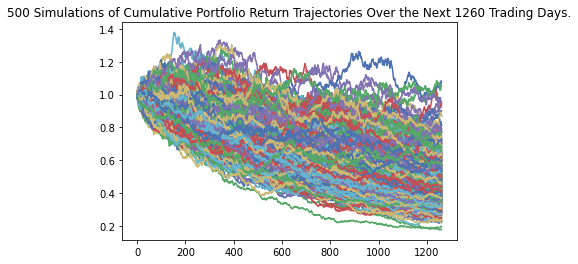

In [132]:
# Visualize the 30-year Monte Carlo simulation by creating an overlay line plot

# TODO: How come 30-year and 1260 Trading days? It has to be 1-year and 252 days period

line_plot_min_portfolio_plot = MC_min_portfolio.plot_simulation()

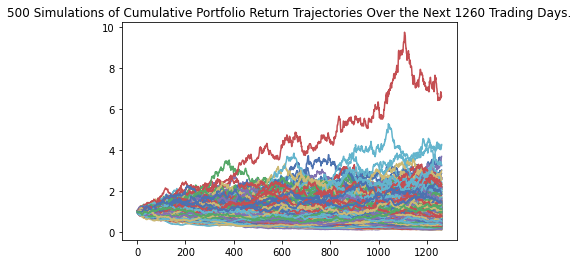

In [133]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
line_plot_max_portfolio_plot = MC_max_portfolio.plot_simulation()

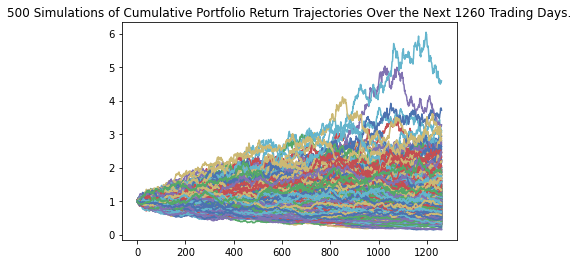

In [134]:
# Visualize the 30-year Monte Carlo simulation by creating an
# overlay line plot
line_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_simulation()

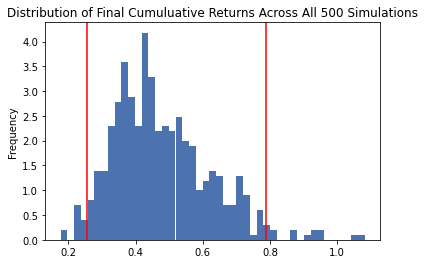

In [135]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
distribution_plot_min_portfolio_plot = MC_min_portfolio.plot_distribution()

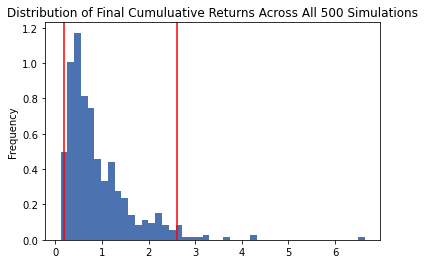

In [136]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
distribution_plot_max_portfolio_plot = MC_max_portfolio.plot_distribution()

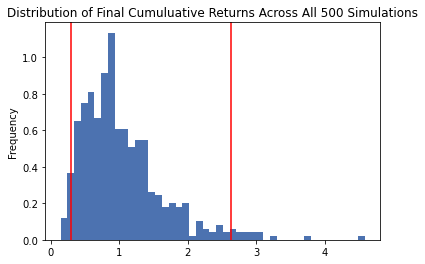

In [137]:
# Visualize the probability distribution of the 30-year Monte Carlo simulation 
# by plotting a histogram
distribution_plot_opt_sharpe_ratio_portfolio_plot = MC_opt_sharpe_ratio_portfolio.plot_distribution()

In [138]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
table_min_portfolio_weight = MC_min_portfolio.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(table_min_portfolio_weight)

count           500.000000
mean              0.477721
std               0.143937
min               0.177023
25%               0.369098
50%               0.452188
75%               0.557687
max               1.081849
95% CI Lower      0.257094
95% CI Upper      0.788773
Name: 1260, dtype: float64


In [139]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
table_max_portfolio_weight = MC_max_portfolio.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(table_max_portfolio_weight)

count           500.000000
mean              0.900986
std               0.712265
min               0.111319
25%               0.427611
50%               0.674170
75%               1.170033
max               6.640810
95% CI Lower      0.186020
95% CI Upper      2.607047
Name: 1260, dtype: float64


In [140]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
table_opt_sharpe_ratio_portfolio_weight = MC_opt_sharpe_ratio_portfolio.summarize_cumulative_return()

# Review the 30-year Monte Carlo summary statistics
print(table_opt_sharpe_ratio_portfolio_weight)

count           500.000000
mean              1.043158
std               0.598148
min               0.144850
25%               0.623478
50%               0.899510
75%               1.311897
max               4.586329
95% CI Lower      0.304201
95% CI Upper      2.631792
Name: 1260, dtype: float64


In [141]:
# Print the initial investment in the portfolio
print(f"The initial investment of the portfolio is ${mpt.initial_test_investment:0.2f}")

The initial investment of the portfolio is $10000.00


In [142]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MIN portfolio

# Get the lower and upper CI values
ci_lower_95per = table_min_portfolio_weight[8]
ci_upper_95per = table_min_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2)

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current MIN portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio is ${investment_pnl_min:0.2f}")


There is a 95% chance that the current MIN portfolio value of $10000.00, will end within the range of $2570.94 and $7887.73.
The actual realized value of the portfolio is $8034.20


In [143]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the MAX portfolio

# Get the lower and upper CI values
ci_lower_95per = table_max_portfolio_weight[8]
ci_upper_95per = table_max_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2)
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current MAX portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio is ${investment_pnl_max:0.2f}")


There is a 95% chance that the current MAX portfolio value of $10000.00, will end within the range of $1860.20 and $26070.47.
The actual realized value of the portfolio is $8127.73


In [144]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the OPT SHARPE RATIO portfolio

# Get the lower and upper CI values
ci_lower_95per = table_opt_sharpe_ratio_portfolio_weight[8]
ci_upper_95per = table_opt_sharpe_ratio_portfolio_weight[9]

# Determine the lower and upper bounds of the expected cumaltiver returns
ci_lower_cumulative_return = round(ci_lower_95per * mpt.initial_test_investment, 2) 
ci_upper_cumulative_return = round(ci_upper_95per * mpt.initial_test_investment, 2) 

# Print the result of your calculations
print()
print(f"There is a 95% chance that the current OPT Sharpe Ratio  portfolio value of ${mpt.initial_test_investment:0.2f}, will end within the range of"
      f" ${ci_lower_cumulative_return:0.2f} and ${ci_upper_cumulative_return:0.2f}.")
print(f"The actual realized value of the portfolio is ${investment_pnl_opt_sharpe_ratio:0.2f}")


There is a 95% chance that the current OPT SHARPE RATIO  portfolio value of $10000.00, will end within the range of $3042.01 and $26317.92.
The actual realized value of the portfolio is $8986.16
